# LAB 2

## Download LLM

In [1]:
import torch 
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("apple/OpenELM-270M-Instruct", trust_remote_code=True)
model.eval()


OpenELMForCausalLM(
  (transformer): OpenELMModel(
    (token_embeddings): Embedding(32000, 1280)
    (layers): ModuleList(
      (0): OpenELMDecoderLayer(
        (attn): OpenELMMultiHeadCausalAttention(
          query_heads=12, key_heads=3, value_heads=3
          (qkv_proj): Linear(in_features=1280, out_features=1152, bias=False)
          (pos_embedding): OpenELMRotaryEmbedding(	model_dim=64, max_seq_length=4096, freq_constant=10000)
          (q_norm): OpenELMRMSNorm(num_features=64, eps=1e-06)
          (k_norm): OpenELMRMSNorm(num_features=64, eps=1e-06)
          (out_proj): Linear(in_features=768, out_features=1280, bias=False)
        )
        (ffn): OpenELMFeedForwardNetwork(
          (ffn_with_glu) : True
          (proj_1): Linear(in_features=1280, out_features=1536, bias=False)
          (proj_2): Linear(in_features=768, out_features=1280, bias=False)
          (act): SiLU()
        )
        (ffn_norm): OpenELMRMSNorm(num_features=1280, eps=1e-06)
        (attn_norm):

### Collect largest matmul in LLM 

In [2]:
import torch
import torch.nn.functional as F
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Initialize dictionary to store activations
activations = {}

prompt = "Arm is a company that" 
inputs = tokenizer(prompt, return_tensors="pt")

# Define a hook function to capture input
def get_activation_input(name):
    def hook(model, input, output):
        # 'input' is a tuple; we take the first element for the input tensor
        activations[name] = output[0]
    return hook

# Select the transformer block and register the hook
layer_idx = 12  # Select the transformer block of your choosing
layer = model.transformer.norm
hook_handle = layer.register_forward_hook(get_activation_input('token_activations'))

# Run the model forward pass
with torch.no_grad():
    model(**inputs)

# Extract the weight matrix and the input activation tensor from the hook
W = model.transformer.token_embeddings.weight.data.clone()
X = activations['token_activations']
hook_handle.remove()
print(f"The collected weight matrix has shape {W.shape[0]}x{W.shape[1]} (output_channels x input_channels)")
print(f"The collected activation tensor has shape {X.shape[0]}x{X.shape[1]} (sequence_length x input_channels)")

The collected weight matrix has shape 32000x1280 (output_channels x input_channels)
The collected activation tensor has shape 6x1280 (sequence_length x input_channels)


### Benchmark torch latency for the matmul

In [5]:
import time

def measure_time():
    start = time.perf_counter()
    with torch.no_grad():
        y = F.linear(X, W, None)
    end = time.perf_counter()
    return (end - start) * 1_000_000  # Convert to microseconds

# Run multiple times and average
times = [measure_time() for _ in range(100)]
avg_time = sum(times) / len(times)
print(f"{avg_time:.2f} µs")

14704.85 µs


### Write Data out so we can benchmark with c++

In [6]:
!mkdir src/cpp/assets/

X.numpy().tofile("src/cpp/assets/x_fp32.bin")
W.numpy().tofile("src/cpp/assets/w_fp32.bin")

mkdir: cannot create directory ‘src/cpp/assets/’: File exists


## Naive Matmul Operator

In [7]:
%%writefile src/cpp/naive/kernel.cpp

#include <stdio.h>
#include <stdlib.h>
#include <time.h>

void matrix_multiply_naive(float* A, float* B, float* C, int M, int K, int N) {
    // # M: the number of rows in the left hand matric (M = A.shape[0])
    // # K: the inner dimensions of the multiple (K == A.shape[1] == B.shape[0])
    // # N: the number of columns in the right hand matrix (N == B.shape[1])
    for (int i = 0; i < M; i++) {
        for (int j = 0; j < N; j++) {
            C[i * N + j] = 0;
            for (int k = 0; k < K; k++) {
                C[i * N + j] += A[i * K + k] * B[k * N + j];
            }
        }
    }
}

Overwriting src/cpp/naive/kernel.cpp


### Benchmark the Naive Operator

In [8]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

!mkdir -p src/cpp/naive/build 

# Navigate to the build directory
%cd src/cpp/naive/build

# Run cmake
!cmake ..

# Build the project using make
!make

print("======> Running benchmark")
# Run the benchmark binary
!./benchmark_naive

# Navigate back to the original directory after execution
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/naive/build
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/naive/build


/home/ubuntu/Generative_AI_on_arm/my_env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


[ 33%] Building CXX object CMakeFiles/benchmark_naive.dir/benchmark_naive.cpp.o
[ 66%] Building CXX object CMakeFiles/benchmark_naive.dir/kernel.cpp.o
[100%] Linking CXX executable benchmark_naive
[100%] Built target benchmark_naive
======> Running benchmark
Time taken: 1201.74 microseconds
/home/ubuntu/Generative_AI_on_arm


# Clone KleidiAI

In [9]:
!git clone https://git.gitlab.arm.com/kleidi/kleidiai.git

fatal: destination path 'kleidiai' already exists and is not an empty directory.


## Understanding the KleidiAI Micro-Kernel

...

## Creating a Kleidi Kernel

...

# FP32 NEON MLA

In [10]:
%%writefile src/cpp/f32_f32_f32p/kernel.cpp

#include <arm_neon.h>

#include "kai_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla.h"
#include "kai_matmul_clamp_f32_f32_f32p_interface.h"


constexpr kai_matmul_clamp_f32_f32_f32p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_n_step_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_nr_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_kr_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_sr_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_lhs_offset_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_rhs_packed_offset_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_dst_offset_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_get_dst_size_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla,
    kai_run_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla};

Overwriting src/cpp/f32_f32_f32p/kernel.cpp


### Build and Benchmark

In [11]:
!mkdir -p src/cpp/f32_f32_f32p/build 

# Navigate to the build directory
%cd src/cpp/f32_f32_f32p/build

# Run cmake
!cmake ..

# Build the project using make
!make

print("======> Running benchmark")
# Run the benchmark binary
!./benchmark_f32

# Navigate back to the original directory after execution
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
[ 10%] Building CXX object CMakeFiles/benchmark_f32.dir/benchmark_f32.cpp.o
[ 20%] Building CXX object CMakeFiles/benchmark_f32.dir/kernel.cpp.o
[ 30%] Linking CXX executable benchmark_f32
[ 50%] Built target benchmark_f32
[ 60%] Building CXX object CMakeFiles/benchmark_f32_scaling.dir/benchmark_f32_scaling.cpp.o
[ 70%] Building CXX object CMakeFiles/benchmark_f32_scaling.dir/kernel.cpp.o
[ 80%] Building C object CMakeFiles/benchmark_f32_scaling.dir/home/ubuntu/Generative_AI_on_arm/kleidiai/kai/ukernels/matmul/matmul_clamp_f32_f32_f32p/kai_matmul_clamp_f32_f32_f32p8x1biasf32_6x8x4_neon_mla.c.o
[ 90%] Building C object CMakeFiles/benchmark_f32_scaling.dir/home/ubuntu/Generative_AI_on_arm/kleidiai/kai/ukernels/matmul/pack/kai_rhs_pack_kxn_f32p8x1biasf32_f32_f32_neon.c.o
[100%] Li

# FP16 NEON MLA 

In [12]:
%%writefile src/cpp/f16_f16_f16p/kernel.cpp

#include <arm_neon.h>

#include "kai_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla.h"
#include "kai_matmul_clamp_f16_f16_f16p_interface.h"

constexpr kai_matmul_clamp_f16_f16_f16p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_n_step_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_nr_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_kr_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_sr_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_lhs_offset_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_rhs_packed_offset_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_dst_offset_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_get_dst_size_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla,
    kai_run_matmul_clamp_f16_f16_f16p16x1biasf16_6x16x8_neon_mla};

Overwriting src/cpp/f16_f16_f16p/kernel.cpp


### Build and Benchmark

In [13]:
!mkdir -p src/cpp/f16_f16_f16p/build 

# Navigate to the build directory
%cd src/cpp/f16_f16_f16p/build

# Run cmake
!cmake ..

# Build the project using make
!make

print("======> Running benchmark")
# Run the benchmark binary
!./benchmark_f16

# Navigate back to the original directory after execution
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
[ 10%] Building CXX object CMakeFiles/benchmark_f16.dir/benchmark_f16.cpp.o
[ 20%] Building CXX object CMakeFiles/benchmark_f16.dir/kernel.cpp.o
[ 30%] Linking CXX executable benchmark_f16
[ 50%] Built target benchmark_f16
[ 60%] Building CXX object CMakeFiles/benchmark_f16_scaling.dir/benchmark_f16_scaling.cpp.o
[ 70%] Building CXX object CMakeFiles/benchmark_f16_scaling.dir/kernel.cpp.o
[ 80%] Linking CXX executable benchmark_f16_scaling
[100%] Built target benchmark_f16_scaling
======> Running benchmark
Time taken: 6.461 microseconds
/home/ubuntu/Generative_AI_on_arm


## DotProd

In [14]:
%%writefile src/cpp/f32_i8_i4_dotprod/kernel.cpp

#include <arm_neon.h>
#include <string>

#include "kai_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod.h"
#include "kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_interface.h"


constexpr kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_n_step_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_mr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_nr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_kr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_sr_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_lhs_packed_offset_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_rhs_packed_offset_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_dst_offset_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_get_dst_size_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod,
    kai_run_matmul_clamp_f32_qsi8d32p1x8_qsi4c32p4x8_1x4x32_neon_dotprod};

Overwriting src/cpp/f32_i8_i4_dotprod/kernel.cpp


### Build and Run 

In [15]:
!mkdir -p src/cpp/f32_i8_i4_dotprod/build 

# Navigate to the build directory
%cd src/cpp/f32_i8_i4_dotprod/build


# Run cmake
!cmake ..

# Build the project using make
!make

print("======> Running benchmark")
# Run the benchmark binary
!./benchmark_dotprod

# Navigate back to the original directory after execution
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_dotprod/build
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_dotprod/build
[  8%] Building CXX object CMakeFiles/benchmark_dotprod.dir/benchmark_i8_dotprod.cpp.o
[ 16%] Building CXX object CMakeFiles/benchmark_dotprod.dir/kernel.cpp.o
[ 25%] Linking CXX executable benchmark_dotprod
[ 50%] Built target benchmark_dotprod
[ 58%] Building CXX object CMakeFiles/benchmark_dotprod_scaling.dir/benchmark_i8_dotprod_scaling.cpp.o
[ 66%] Building CXX object CMakeFiles/benchmark_dotprod_scaling.dir/kernel.cpp.o
[ 75%] Linking CXX executable benchmark_dotprod_scaling
[100%] Built target benchmark_dotprod_scaling
======> Running benchmark
Time taken: 12.705 microseconds
/home/ubuntu/Generative_AI_on_arm


## I8MM

In [16]:
%%writefile src/cpp/f32_i8_i4_i8mm/kernel.cpp

#include <arm_neon.h>
#include "kai_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm.h"
#include "kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_interface.h"


constexpr kai_matmul_clamp_f32_qsi8d32p_qsi4c32p_ukernel ukernel{
    kai_get_m_step_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_n_step_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_mr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_nr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_kr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_sr_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_lhs_packed_offset_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_rhs_packed_offset_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_dst_offset_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_get_dst_size_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm,
    kai_run_matmul_clamp_f32_qsi8d32p4x8_qsi4c32p4x8_8x4x32_neon_i8mm};



Overwriting src/cpp/f32_i8_i4_i8mm/kernel.cpp


### Build and Run 

In [17]:
!mkdir -p src/cpp/f32_i8_i4_dotprod/build 

# Navigate to the build directory
%cd src/cpp/f32_i8_i4_i8mm/build


# Run cmake
!cmake ..

# Build the project using make
!make

print("======> Running benchmark")
# Run the benchmark binary
!./benchmark_i8mm

# Navigate back to the original directory after execution
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_i8mm/build
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_i8mm/build
[  8%] Building CXX object CMakeFiles/benchmark_i8_i8mm.dir/benchmark_i8_i8mm.cpp.o
[ 16%] Building CXX object CMakeFiles/benchmark_i8_i8mm.dir/kernel.cpp.o
[ 25%] Linking CXX executable benchmark_i8_i8mm
[ 50%] Built target benchmark_i8_i8mm
[ 58%] Building CXX object CMakeFiles/benchmark_i8_i8mm_scaling.dir/benchmark_i8_i8mm_scaling.cpp.o
[ 66%] Building CXX object CMakeFiles/benchmark_i8_i8mm_scaling.dir/kernel.cpp.o
[ 75%] Linking CXX executable benchmark_i8_i8mm_scaling
[100%] Built target benchmark_i8_i8mm_scaling
======> Running benchmark
/bin/bash: line 1: ./benchmark_i8mm: No such file or directory
/home/ubuntu/Generative_AI_on_arm


### Plot Latency Scaling 

In [38]:
%%writefile src/cpp/common/sizes.cpp

int sizes[] = {32, 64, 128, 256, 512, 1024, 2048};

Overwriting src/cpp/common/sizes.cpp


if changing sizes you should build the code again. 

In [39]:
%cd src/cpp/f32_f32_f32p/build
!cmake .. && make
%cd -
%cd src/cpp/f16_f16_f16p/build
!cmake .. && make
%cd -
%cd src/cpp/f32_i8_i4_dotprod/build
!cmake .. && make
%cd -
%cd src/cpp/f32_i8_i4_i8mm/build
!cmake .. && make
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
[ 50%] Built target benchmark_f32
[ 60%] Building CXX object CMakeFiles/benchmark_f32_scaling.dir/benchmark_f32_scaling.cpp.o


/home/ubuntu/Generative_AI_on_arm/my_env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


[ 70%] Linking CXX executable benchmark_f32_scaling
[100%] Built target benchmark_f32_scaling
/home/ubuntu/Generative_AI_on_arm
/home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
[ 50%] Built target benchmark_f16
[ 60%] Building CXX object CMakeFiles/benchmark_f16_scaling.dir/benchmark_f16_scaling.cpp.o
[ 70%] Linking CXX executable benchmark_f16_scaling
[100%] Built target benchmark_f16_scaling
/home/ubuntu/Generative_AI_on_arm
/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_dotprod/build
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_dotprod/build
[ 50%] Built target benchmark_dotprod
[ 58%] Building CXX object CMakeFiles/benchmark_dotprod_scaling.dir/benchmark_i8_dotprod_scaling.cpp.o
[ 66%] Linking CXX executable benchmark_dot

Run the scaling benchmarks 

In [44]:
%cd src/cpp/f32_f32_f32p/build
!./benchmark_f32_scaling
%cd -
%cd src/cpp/f16_f16_f16p/build
!./benchmark_f16_scaling
%cd -
%cd src/cpp/f32_i8_i4_dotprod/build
!./benchmark_dotprod_scaling
%cd -
%cd src/cpp/f32_i8_i4_i8mm/build
!./benchmark_i8_i8mm_scaling
%cd -

/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_f32_f32p/build
Time taken: 0.002 microseconds
Time taken: 0.012 microseconds
Time taken: 0.079 microseconds
Time taken: 0.764 microseconds
Time taken: 6.33 microseconds
Time taken: 51.515 microseconds
Time taken: 436.75 microseconds
/home/ubuntu/Generative_AI_on_arm
/home/ubuntu/Generative_AI_on_arm/src/cpp/f16_f16_f16p/build
Time taken: 0.002 microseconds
Time taken: 0.007 microseconds
Time taken: 0.042 microseconds
Time taken: 0.355 microseconds
Time taken: 3.134 microseconds
Time taken: 26.466 microseconds
Time taken: 229.972 microseconds
/home/ubuntu/Generative_AI_on_arm
/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_dotprod/build
Time taken: 0.001 microseconds
Time taken: 0.013 microseconds
Time taken: 0.12 microseconds
Time taken: 0.655 microseconds
Time taken: 5.967 microseconds
Time taken: 50.382 microseconds
Time taken: 425.883 microseconds
/home/ubuntu/Generative_AI_on_arm
/home/ubuntu/Generative_AI_on_arm/src/cpp/f32_i8_i4_i

## Plot the results for kleidiAI

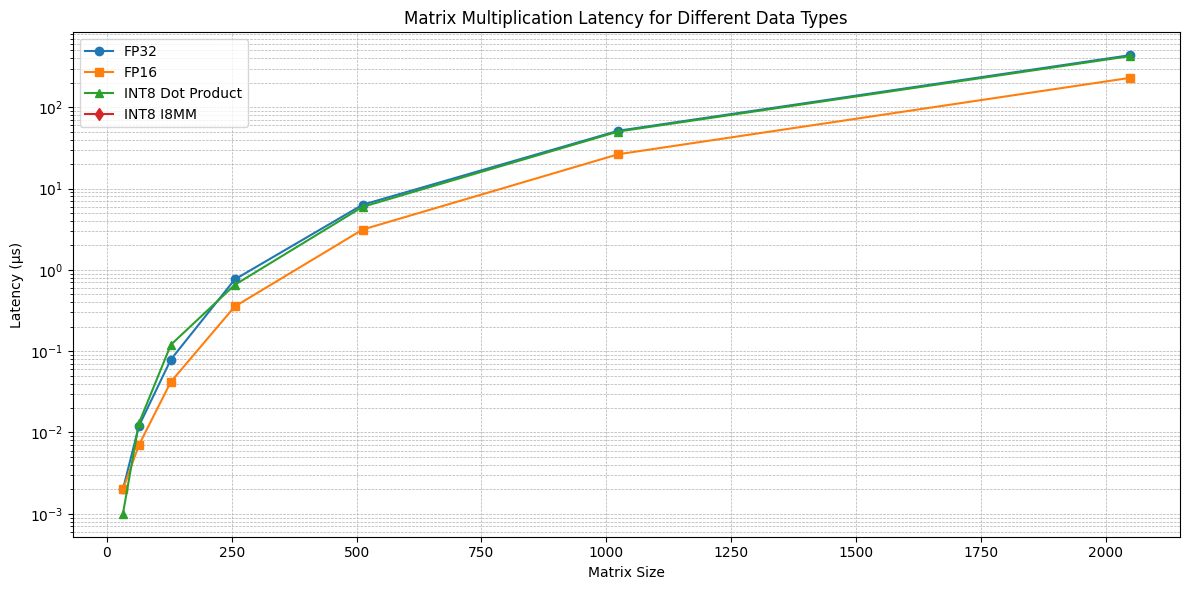

In [45]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 

f32_data = pd.read_csv("src/cpp/results/f32_scaling_results.csv")
f16_data = pd.read_csv("src/cpp/results/f16_scaling_results.csv")
int8_dotprod_data = pd.read_csv("src/cpp/results/i8_dotprod_scaling_results.csv")
int8_i8mm_data = pd.read_csv("src/cpp/results/i8_i8mm_scaling_results.csv")


# Plotting the results
plt.figure(figsize=(12, 6))

# Plot each dataset
plt.plot(f32_data['Size'], f32_data['Latency(us)'], label="FP32", marker='o')
plt.plot(f16_data['Size'], f16_data['Latency(us)'], label="FP16", marker='s')
plt.plot(int8_dotprod_data['Size'], int8_dotprod_data['Latency(us)'], label="INT8 Dot Product", marker='^')
plt.plot(int8_i8mm_data['Size'], int8_i8mm_data['Latency(us)'], label="INT8 I8MM", marker='d')

# Add labels and title
plt.xlabel("Matrix Size")
plt.ylabel("Latency (µs)")
plt.title("Matrix Multiplication Latency for Different Data Types")
plt.yscale('log')  # Use log scale for latency if the values span multiple orders of magnitude
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()
